In [1]:
import os
import numpy as np
import json
import uuid
from datetime import datetime
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from flask import Flask, request, jsonify
import mysql.connector
from mysql.connector import Error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

nlp = spacy.load("en_core_web_md")

# ------------------ Vector Database Configuration ------------------ #

In [2]:
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'vector_db'
}

# ------------------ Utility Functions ------------------ #

In [3]:
def keep_nouns_adjs(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ in ["NOUN", "PROPN", "ADJ"] and not token.is_stop and not token.is_punct
    ]
    return " ".join(tokens)

def text_to_vector(text):
    clean_text = keep_nouns_adjs(text)
    doc = nlp(clean_text)
    return doc.vector

# ------------------ Vector Database Class ------------------ #

In [4]:
class VectorDatabase:
    def __init__(self, db_config, similarity_threshold=0.6):
        self.similarity_threshold = similarity_threshold
        self.db_config = db_config
        self._init_db()
    
    def _connect(self):
        return mysql.connector.connect(**self.db_config)
    
    def _init_db(self):
        conn = self._connect()
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS vector_database (
                id VARCHAR(255) PRIMARY KEY,
                text TEXT NOT NULL,
                vector TEXT NOT NULL,
                timestamp VARCHAR(50) NOT NULL
            )
        """)
        conn.commit()
        cursor.close()
        conn.close()
    
    def add_or_find_duplicate(self, text):
        sim = 0.0
        new_vector = text_to_vector(text)
        conn = self._connect()
        cursor = conn.cursor()
        cursor.execute("SELECT id, text, vector, timestamp FROM vector_database")
        rows = cursor.fetchall()
        
        
        for row in rows:
            entry_id, entry_text, entry_vector_json, timestamp = row
            entry_vector = np.array(json.loads(entry_vector_json))
            sim = cosine_similarity(new_vector.reshape(1, -1), entry_vector.reshape(1, -1))[0][0]
            
            if sim >= self.similarity_threshold:
                cursor.close()
                conn.close()
                return {
                    'status': 'duplicate',
                    'similarity': sim,
                    'id': entry_id,
                    'text': entry_text,
                    'timestamp': timestamp
                }
        
        entry_id = str(uuid.uuid4())[:8]
        timestamp = datetime.now().isoformat()
        cursor.execute(
            "INSERT INTO vector_database (id, text, vector, timestamp) VALUES (%s, %s, %s, %s)",
            (entry_id, text, json.dumps(new_vector.tolist()), timestamp)
        )
        conn.commit()
        cursor.close()
        conn.close()
        
        return {
            'status': 'added',
            'similarity':sim,
            'id': entry_id,
            'text': text,
            'timestamp': timestamp
        }
    
    def calculate_similarity(self, text1, text2):
        """Calculate similarity between two texts without adding to database"""
        vec1 = text_to_vector(text1)
        vec2 = text_to_vector(text2)
        sim = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
        return sim
    
    def clear_database(self):
        """Clear all entries from the database"""
        conn = self._connect()
        cursor = conn.cursor()
        cursor.execute("DELETE FROM vector_database")
        conn.commit()
        cursor.close()
        conn.close()

# ------------------ Testing With Synthetic Dataset ------------------ #

In [5]:
df = pd.read_csv("dataset.csv")
df.head()

,text1,text2,label
0,Basketball helps me stay active and improves m...,Playing basketball is great for fitness and te...,1
1,I plan at least one trip every year to a new p...,Every year I make sure to visit a place I’ve n...,1
2,I enjoy reading fantasy books filled with magi...,"Fantasy novels with dragons, magic, and heroes...",1
3,Swimming helps me relax and build stamina.,I love reading books about space exploration a...,0
4,I go jogging every morning to stay fit and cle...,I take a walk every morning to refresh my thou...,0


In [6]:
similarity_threshold = 0.6
db = VectorDatabase(DB_CONFIG, similarity_threshold=similarity_threshold)
db.clear_database()

In [14]:
# Cell 3 — Corrected evaluation loop using db.add_or_find_duplicate()
predictions = []
true_labels = []
similarity_scores = []

for idx, row in df.iterrows():
    text1 = row['text1']
    text2 = row['text2']
    true_label = int(row['label'])

    # Step 1: clear DB
    db.clear_database()

    # Step 2: insert text1
    db.add_or_find_duplicate(text1)

    # Step 3: compute similarity by calling the DB method on text2
    result = db.add_or_find_duplicate(text2)
    sim = result.get('similarity', 0.0)

    # Step 4: store results
    similarity_scores.append(sim)
    pred = 1 if sim >= similarity_threshold else 0
    predictions.append(pred)
    true_labels.append(true_label)

    # Step 5: optional debugging output
    if idx < 5:
        print(f"[{idx}]\ttext1[:60]: {text1[:60]!s}")
        print(f"\ttext2[:60]: {text2[:60]!s}")
        print(f"\tsim={sim:.4f}  true={true_label} pred={pred}\n")


[0]	text1[:60]: Basketball helps me stay active and improves my teamwork ski
	text2[:60]: Playing basketball is great for fitness and teamwork.
	sim=0.7864  true=1 pred=1

[1]	text1[:60]: I plan at least one trip every year to a new place.
	text2[:60]: Every year I make sure to visit a place I’ve never been befo
	sim=0.8201  true=1 pred=1

[2]	text1[:60]: I enjoy reading fantasy books filled with magic, dragons, an
	text2[:60]: Fantasy novels with dragons, magic, and heroes capture my im
	sim=0.8973  true=1 pred=1

[3]	text1[:60]: Swimming helps me relax and build stamina.
	text2[:60]: I love reading books about space exploration and aliens.
	sim=0.2653  true=0 pred=0

[4]	text1[:60]: I go jogging every morning to stay fit and clear my mind.
	text2[:60]: I take a walk every morning to refresh my thoughts and keep 
	sim=0.7459  true=0 pred=1



# ------------------ Metrics ------------------

In [8]:
cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
specificity = tn / (tn + fp) if (tn + fp) else 0

print("\n" + "=" * 70)
print("FINAL EVALUATION RESULTS")
print("=" * 70)
print(f"Accuracy     : {accuracy:.3f}")
print(f"Precision    : {precision:.3f}")
print(f"Recall       : {recall:.3f}")
print(f"F1-Score     : {f1_score:.3f}")
print(f"Specificity  : {specificity:.3f}")
print()
print(f"True Positives : {tp}")
print(f"True Negatives : {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print("=" * 70)


FINAL EVALUATION RESULTS
Accuracy     : 0.912
Precision    : 0.906
Recall       : 0.935
F1-Score     : 0.921
Specificity  : 0.885

True Positives : 29
True Negatives : 23
False Positives: 3
False Negatives: 2


# Confusion Matrix

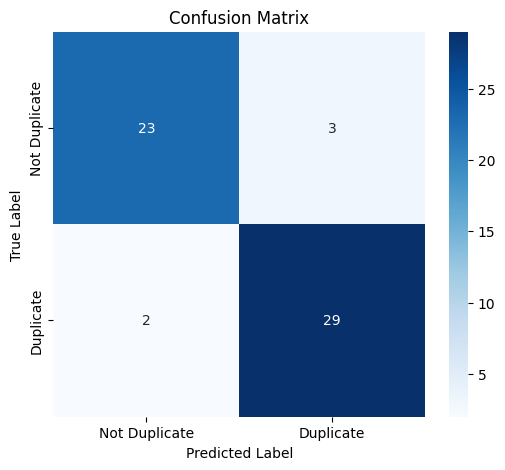

In [9]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Duplicate', 'Duplicate'],
            yticklabels=['Not Duplicate', 'Duplicate'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Bar Chart

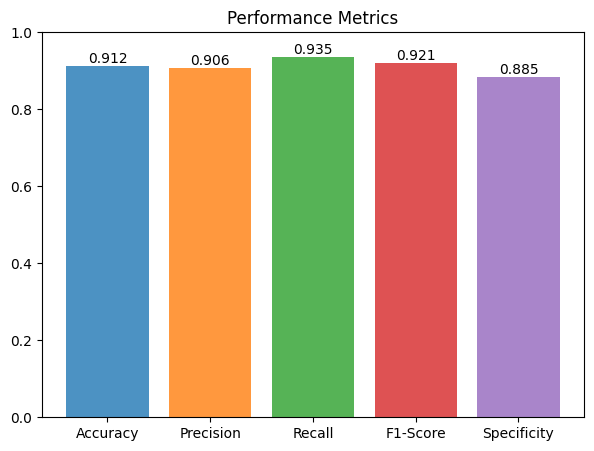

In [10]:
plt.figure(figsize=(7, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
values = [accuracy, precision, recall, f1_score, specificity]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.ylim(0, 1)
plt.title('Performance Metrics')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{bar.get_height():.3f}", ha='center', va='bottom')
plt.show()

# ROC Curve

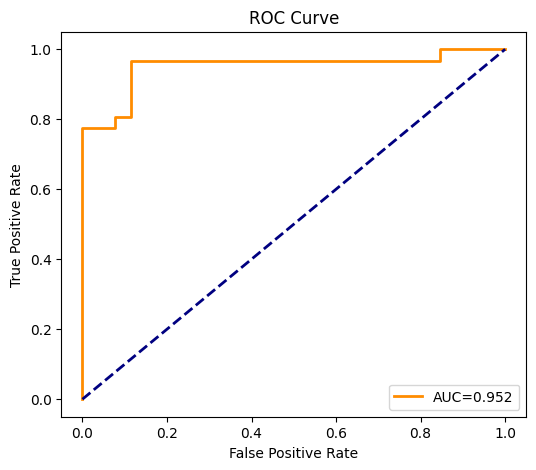

In [11]:
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#  Precision-Recall Curve

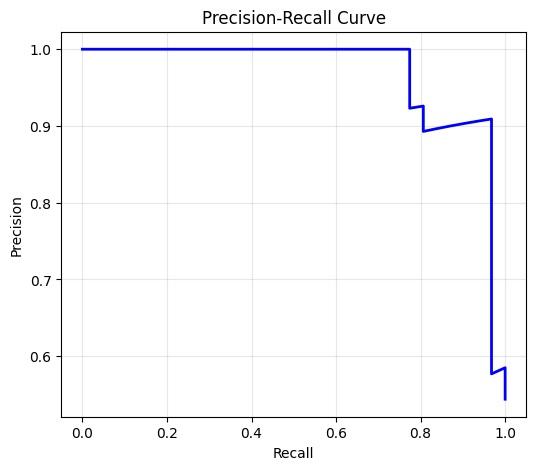

In [12]:
plt.figure(figsize=(6, 5))
precision_curve, recall_curve, _ = precision_recall_curve(true_labels, similarity_scores)
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.show()

# Similarity Distribution

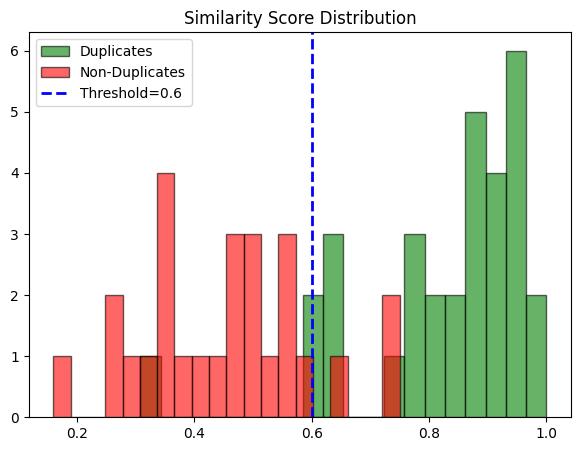

In [13]:
plt.figure(figsize=(7, 5))
duplicate_scores = [similarity_scores[i] for i in range(len(similarity_scores)) if true_labels[i] == 1]
non_duplicate_scores = [similarity_scores[i] for i in range(len(similarity_scores)) if true_labels[i] == 0]
plt.hist(duplicate_scores, bins=20, alpha=0.6, label='Duplicates', color='green', edgecolor='black')
plt.hist(non_duplicate_scores, bins=20, alpha=0.6, label='Non-Duplicates', color='red', edgecolor='black')
plt.axvline(similarity_threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold={similarity_threshold}')
plt.title('Similarity Score Distribution')
plt.legend()
plt.show()